# Validation: Does the pattern hold up when stratifying across different lighting conditions? Do we see very different lighting between west and east?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import cv2
from scipy.stats import chi2_contingency
from sklearn.metrics import cohen_kappa_score

# anova stuff
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

In [2]:
color_df = pd.read_csv('../datasets/1-clusters/cluster1.csv')

# Add darkness column and region

#### If darkness from HSL

In [3]:
# in hsl, where "l" is lightness. 
# we can then subtract l from 1 for "intensity" = darkness
darkness = []
for hsl in color_df.hsl:
    # parse the text hsl value into a list of 3 str vals
    # (function generating this val is in notebook 5)
    h,s,l = hsl.strip('()').split(',')
    darkness.append(1-float(l))
color_df['darkness'] = darkness

#### If darkness from CIELAB (what we're going with for now)

In [4]:
darkness = [(255-int(i.strip('()').split(', ')[0]))/255 for i in color_df.lab]
color_df['darkness'] = darkness

#### add a region column

In [5]:
# set region split longitude
focal_lon = -100 
# make a "region" column based on longitude
color_df['region'] = color_df['longitude'].apply(lambda x: 'East' if x > focal_lon else 'West')

# Robin's Validation

In [6]:
robin_val = pd.read_csv('./validation_subset_Robin.csv')
robin_val.columns = ['image_idx', 'lighting', 'monarda']
robin_val.to_csv('./validation_subset_Robin.csv',index=False)

In [7]:
robin_val

,image_idx,lighting,monarda
0,10,h,NaN
1,143,s,NaN
2,177,s,NaN
3,382,s,NaN
4,531,h,NaN
...,...,...,...
495,40750,s,NaN
496,40772,s,NaN
497,40822,s,NaN
498,40894,h,NaN


In [8]:
# how many show monarda flowers 
robin_val.monarda.isna().sum()

np.int64(500)

In [9]:
sunlist = list(robin_val[robin_val.lighting.eq('s')].image_idx)
shadelist = list(robin_val[robin_val.lighting.eq('h')].image_idx)
partiallist = list(robin_val[robin_val.lighting.eq('p')].image_idx)

In [10]:
sun_df = color_df[(color_df.image_idx.isin(sunlist))]
shade_df = color_df[(color_df.image_idx.isin(shadelist))]
partial_df = color_df[(color_df.image_idx.isin(partiallist))]

In [11]:
print(f"Number of overall sun observations: {len(sunlist)}")
print(f"    West: {np.sum(sun_df.longitude < -100)}")
print(f"    East: {np.sum(sun_df.longitude > -100)}")
print(f"Number of overall shade observations: {len(shadelist)}")
print(f"    West: {np.sum(shade_df.longitude < -100)}")
print(f"    East: {np.sum(shade_df.longitude > -100)}")
print(f"Number of overall partial observations: {len(partiallist)}")
print(f"    West: {np.sum(partial_df.longitude < -100)}")
print(f"    East: {np.sum(partial_df.longitude > -100)}")

Number of overall sun observations: 238
    West: 124
    East: 114
Number of overall shade observations: 184
    West: 86
    East: 98
Number of overall partial observations: 78
    West: 40
    East: 38


In [12]:
# replace these with your actual counts
table = np.array([[np.sum(sun_df.longitude < -100), np.sum(shade_df.longitude < -100), np.sum(partial_df.longitude < -100)],
                  [np.sum(sun_df.longitude > -100), np.sum(shade_df.longitude > -100), np.sum(partial_df.longitude > -100)]])

chi2, p, dof, expected = chi2_contingency(table, correction=False) # two degrees of freedom so no yates correction
print(f"χ² = {chi2:.2f}, df = {dof}, p-value = {p:.4f}")

χ² = 1.25, df = 2, p-value = 0.5342


# Boxplots

## get median color for each region

In [13]:
# conversion functions (from notebook 5)
def rgb_to_hex(rgb):
    # rgb should be a tuple like (R, G, B)
    return '#{:02x}{:02x}{:02x}'.format(*rgb)
def lab_to_rgb(lab):
    """convert (L,a,b) in OpenCV's Lab to (r,g,b) in [0,255]"""
    arr = np.array([[lab]], dtype=np.uint8)
    rgb = cv2.cvtColor(arr, cv2.COLOR_LAB2RGB)[0][0]
    return tuple(int(x) for x in rgb)

In [14]:
#####
#SUN#
#####

### WEST
west_sun = list(sun_df[sun_df.region.eq('West')].lab)
west_sun = [i.strip('()').split(', ') for i in west_sun]
west_sun = [[float(q) for q in i] for i in west_sun]

median_lab = np.median(west_sun,axis=0) # lab color
sun_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_sun = list(sun_df[sun_df.region.eq('East')].lab)
east_sun = [i.strip('()').split(', ') for i in east_sun]
east_sun = [[float(q) for q in i] for i in east_sun]

median_lab = np.median(east_sun,axis=0) # lab color
sun_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

#######
#SHADE#
#######

### WEST
west_shade = list(shade_df[shade_df.region.eq('West')].lab)
west_shade = [i.strip('()').split(', ') for i in west_shade]
west_shade = [[float(q) for q in i] for i in west_shade]

median_lab = np.median(west_shade,axis=0) # lab color
shade_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_shade = list(shade_df[shade_df.region.eq('East')].lab)
east_shade = [i.strip('()').split(', ') for i in east_shade]
east_shade = [[float(q) for q in i] for i in east_shade]

median_lab = np.median(east_shade,axis=0) # lab color
shade_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color


#########
#PARTIAL#
#########

### WEST
west_partial = list(partial_df[partial_df.region.eq('West')].lab)
west_partial = [i.strip('()').split(', ') for i in west_partial]
west_partial = [[float(q) for q in i] for i in west_partial]

median_lab = np.median(west_partial,axis=0) # lab color
partial_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_partial = list(partial_df[partial_df.region.eq('East')].lab)
east_partial = [i.strip('()').split(', ') for i in east_partial]
east_partial = [[float(q) for q in i] for i in east_partial]

median_lab = np.median(east_partial,axis=0) # lab color
partial_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

## Sun individual boxplots

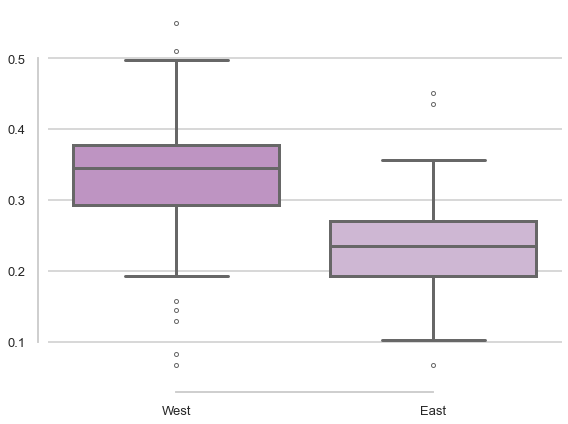

t-statistic: -10.573
p-value: 0.00000


In [15]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=sun_df,
    hue='region',
    legend=False,
    palette=[sun_west_median_color, sun_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = sun_df[sun_df['region'] == 'West']['darkness']
east_darkness = sun_df[sun_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## Shade individual boxplots

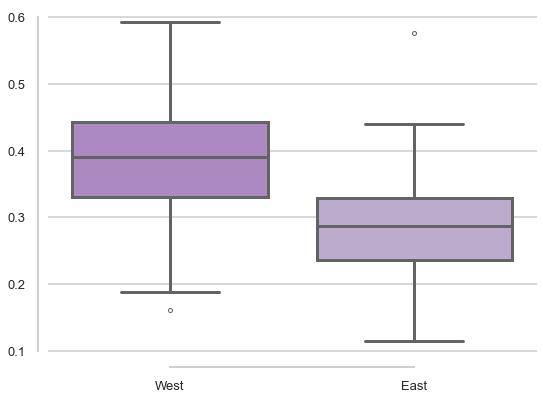

t-statistic: -8.614
p-value: 0.00000


In [16]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=shade_df,
    hue='region',
    legend=False,
    palette=[shade_west_median_color, shade_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = shade_df[shade_df['region'] == 'West']['darkness']
east_darkness = shade_df[shade_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## Partial individual boxplots

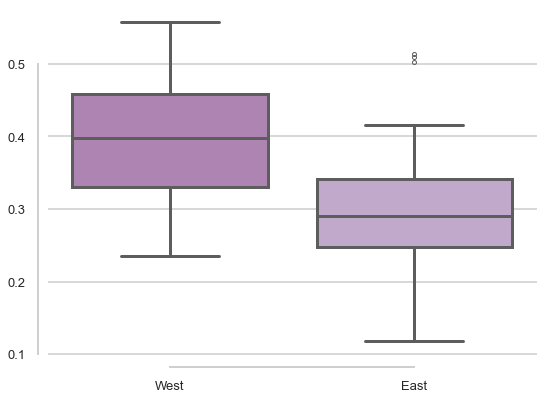

t-statistic: -4.501
p-value: 0.00002


In [17]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=partial_df,
    hue='region',
    legend=False,
    palette=[partial_west_median_color, partial_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = partial_df[partial_df['region'] == 'West']['darkness']
east_darkness = partial_df[partial_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## All three together:

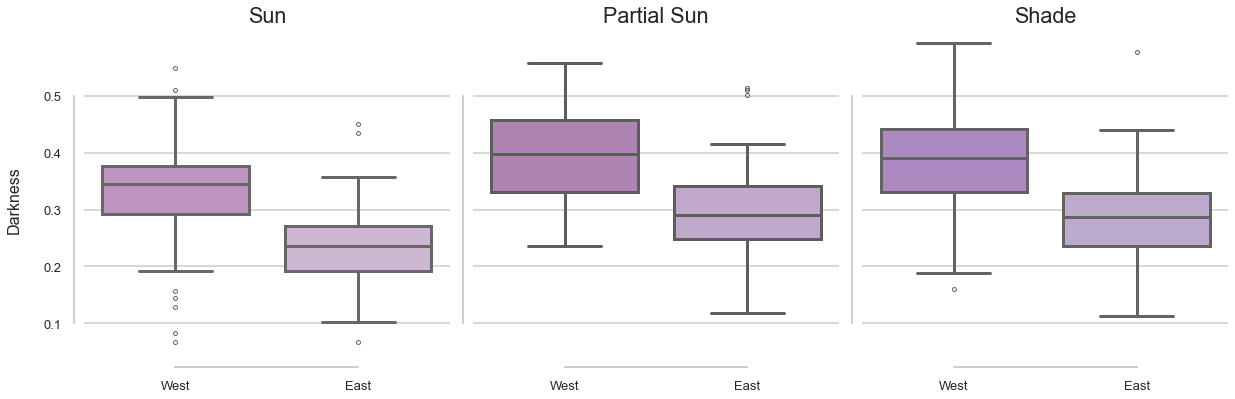

In [18]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# 1 row, 3 columns, share y-axis
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(18, 6))

# PLOT 1: sun_df
sns.boxplot(
    x='region', y='darkness', data=sun_df,
    hue='region', legend=False,
    palette=[sun_west_median_color, sun_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[0]
)
axes[0].set_title('Sun')
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
axes[0].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[0], offset=10, trim=True)

# PLOT 2: partial_df
sns.boxplot(
    x='region', y='darkness', data=partial_df,
    hue='region', legend=False,
    palette=[partial_west_median_color, partial_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[1]
)
axes[1].set_title('Partial Sun')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
axes[1].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[1], offset=10, trim=True)

# PLOT 3: shade_df
sns.boxplot(
    x='region', y='darkness', data=shade_df,
    hue='region', legend=False,
    palette=[shade_west_median_color, shade_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[2]
)
axes[2].set_title('Shade')
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)
axes[2].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[2], offset=10, trim=True)

# y label
fig.text(0.04, 0.5, 'Darkness', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~~~~~~~~

# Sam's Validation

In [19]:
sam_val = pd.read_csv('./validation_subset_Sam.csv')
sam_val.columns = ['image_idx', 'lighting', 'monarda']
sam_val.to_csv('./validation_subset_Sam.csv',index=False)

In [20]:
sam_val

,image_idx,lighting,monarda
0,10,h,NaN
1,143,s,NaN
2,177,s,NaN
3,382,p,NaN
4,531,h,NaN
...,...,...,...
495,40750,h,NaN
496,40772,s,NaN
497,40822,s,NaN
498,40894,h,NaN


In [21]:
# how many show monarda flowers
sam_val.monarda.isna().sum()

np.int64(500)

In [22]:
# how many agree with Robin?
np.sum(np.array(robin_val.lighting) == np.array(sam_val.lighting))

np.int64(371)

In [23]:
sunlist = list(sam_val[sam_val.lighting.eq('s')].image_idx)
shadelist = list(sam_val[sam_val.lighting.eq('h')].image_idx)
partiallist = list(sam_val[sam_val.lighting.eq('p')].image_idx)

In [24]:
np.sum(sam_val.lighting.eq('n'))

np.int64(1)

In [25]:
sun_df = color_df[(color_df.image_idx.isin(sunlist))]
shade_df = color_df[(color_df.image_idx.isin(shadelist))]
partial_df = color_df[(color_df.image_idx.isin(partiallist))]

In [26]:
print(f"Number of overall sun observations: {len(sunlist)}")
print(f"    West: {np.sum(sun_df.longitude < -100)}")
print(f"    East: {np.sum(sun_df.longitude > -100)}")
print(f"Number of overall shade observations: {len(shadelist)}")
print(f"    West: {np.sum(shade_df.longitude < -100)}")
print(f"    East: {np.sum(shade_df.longitude > -100)}")
print(f"Number of overall partial observations: {len(partiallist)}")
print(f"    West: {np.sum(partial_df.longitude < -100)}")
print(f"    East: {np.sum(partial_df.longitude > -100)}")

Number of overall sun observations: 234
    West: 113
    East: 121
Number of overall shade observations: 167
    West: 82
    East: 85
Number of overall partial observations: 98
    West: 54
    East: 44


In [27]:
54+44+82+85+113+121

499

In [28]:
# replace these with your actual counts
table = np.array([[np.sum(sun_df.longitude < -100), np.sum(shade_df.longitude < -100), np.sum(partial_df.longitude < -100)],
                  [np.sum(sun_df.longitude > -100), np.sum(shade_df.longitude > -100), np.sum(partial_df.longitude > -100)]])

chi2, p, dof, expected = chi2_contingency(table, correction=False) # two degrees of freedom so no yates correction
print(f"χ² = {chi2:.2f}, df = {dof}, p-value = {p:.4f}")

χ² = 1.35, df = 2, p-value = 0.5102


# Boxplots

## get median color for each region

In [29]:
# conversion functions (from notebook 5)
def rgb_to_hex(rgb):
    # rgb should be a tuple like (R, G, B)
    return '#{:02x}{:02x}{:02x}'.format(*rgb)
def lab_to_rgb(lab):
    """convert (L,a,b) in OpenCV's Lab to (r,g,b) in [0,255]"""
    arr = np.array([[lab]], dtype=np.uint8)
    rgb = cv2.cvtColor(arr, cv2.COLOR_LAB2RGB)[0][0]
    return tuple(int(x) for x in rgb)

In [30]:
#####
#SUN#
#####

### WEST
west_sun = list(sun_df[sun_df.region.eq('West')].lab)
west_sun = [i.strip('()').split(', ') for i in west_sun]
west_sun = [[float(q) for q in i] for i in west_sun]

median_lab = np.median(west_sun,axis=0) # lab color
sun_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_sun = list(sun_df[sun_df.region.eq('East')].lab)
east_sun = [i.strip('()').split(', ') for i in east_sun]
east_sun = [[float(q) for q in i] for i in east_sun]

median_lab = np.median(east_sun,axis=0) # lab color
sun_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

#######
#SHADE#
#######

### WEST
west_shade = list(shade_df[shade_df.region.eq('West')].lab)
west_shade = [i.strip('()').split(', ') for i in west_shade]
west_shade = [[float(q) for q in i] for i in west_shade]

median_lab = np.median(west_shade,axis=0) # lab color
shade_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_shade = list(shade_df[shade_df.region.eq('East')].lab)
east_shade = [i.strip('()').split(', ') for i in east_shade]
east_shade = [[float(q) for q in i] for i in east_shade]

median_lab = np.median(east_shade,axis=0) # lab color
shade_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color


#########
#PARTIAL#
#########

### WEST
west_partial = list(partial_df[partial_df.region.eq('West')].lab)
west_partial = [i.strip('()').split(', ') for i in west_partial]
west_partial = [[float(q) for q in i] for i in west_partial]

median_lab = np.median(west_partial,axis=0) # lab color
partial_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_partial = list(partial_df[partial_df.region.eq('East')].lab)
east_partial = [i.strip('()').split(', ') for i in east_partial]
east_partial = [[float(q) for q in i] for i in east_partial]

median_lab = np.median(east_partial,axis=0) # lab color
partial_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

## Sun individual boxplots

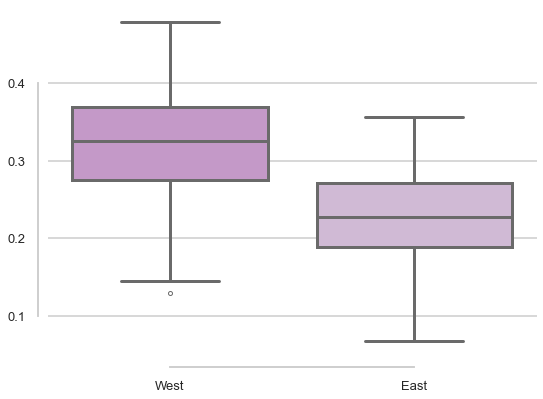

t-statistic: -11.643
p-value: 0.00000


In [31]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=sun_df,
    hue='region',
    legend=False,
    palette=[sun_west_median_color, sun_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = sun_df[sun_df['region'] == 'West']['darkness']
east_darkness = sun_df[sun_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## Shade individual boxplots

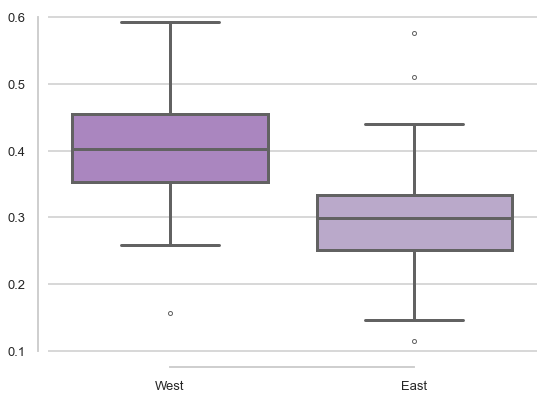

t-statistic: -9.004
p-value: 0.00000


In [32]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=shade_df,
    hue='region',
    legend=False,
    palette=[shade_west_median_color, shade_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = shade_df[shade_df['region'] == 'West']['darkness']
east_darkness = shade_df[shade_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## Partial individual boxplots

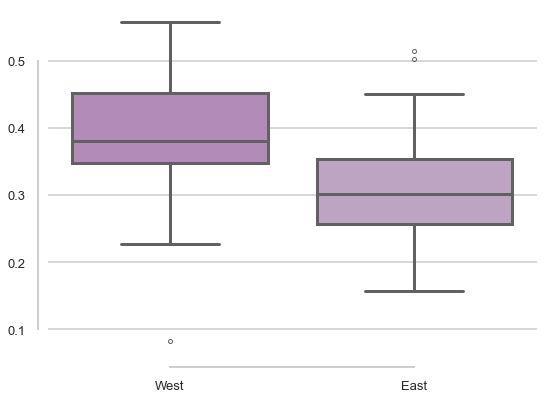

t-statistic: -4.750
p-value: 0.00001


In [33]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=partial_df,
    hue='region',
    legend=False,
    palette=[partial_west_median_color, partial_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = partial_df[partial_df['region'] == 'West']['darkness']
east_darkness = partial_df[partial_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## All three together:

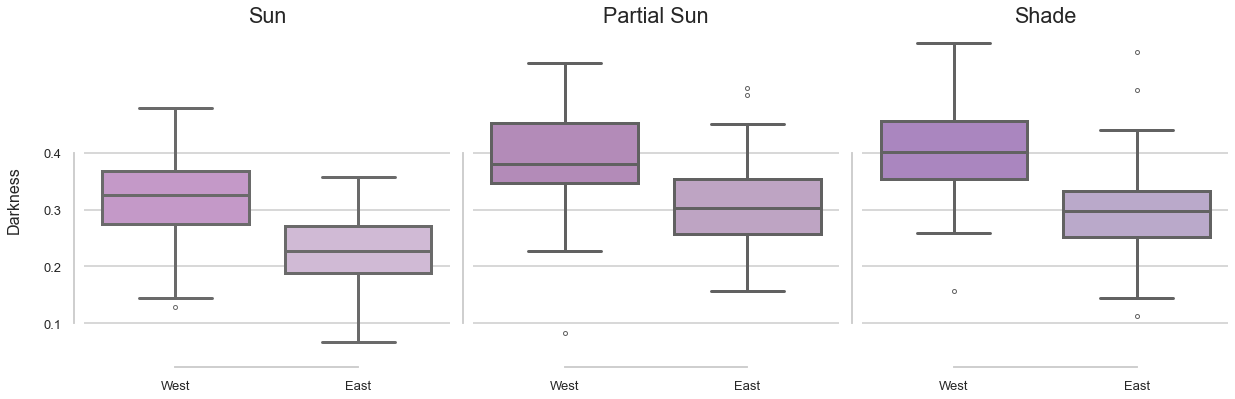

In [34]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# 1 row, 3 columns, share y-axis
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(18, 6))

# PLOT 1: sun_df
sns.boxplot(
    x='region', y='darkness', data=sun_df,
    hue='region', legend=False,
    palette=[sun_west_median_color, sun_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[0]
)
axes[0].set_title('Sun')
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
axes[0].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[0], offset=10, trim=True)

# PLOT 2: partial_df
sns.boxplot(
    x='region', y='darkness', data=partial_df,
    hue='region', legend=False,
    palette=[partial_west_median_color, partial_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[1]
)
axes[1].set_title('Partial Sun')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
axes[1].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[1], offset=10, trim=True)

# PLOT 3: shade_df
sns.boxplot(
    x='region', y='darkness', data=shade_df,
    hue='region', legend=False,
    palette=[shade_west_median_color, shade_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[2]
)
axes[2].set_title('Shade')
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)
axes[2].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[2], offset=10, trim=True)

# y label
fig.text(0.04, 0.5, 'Darkness', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

# ~~~~~~~~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~~~~~~~~

# ~~~~~~~~~~~~~~~~~~~~~

# Intersected Validation

#### cohen's k for agreement

In [35]:
kappa = cohen_kappa_score(np.array(sam_val.lighting), np.array(robin_val.lighting))
print(f"Cohen's κ = {kappa:.3f}")

Cohen's κ = 0.586


In [36]:
N = len(np.array(sam_val.lighting)); nboot = 10_000
boot = [ cohen_kappa_score(np.array(sam_val.lighting)[idx], np.array(robin_val.lighting)[idx]) for idx in np.random.randint(0, N, (nboot, N)) ]
lo, hi = np.percentile(boot, [2.5, 97.5])
print(f"95% CI: {lo:.3f} - {hi:.3f}")

95% CI: 0.525 - 0.646


#### consensus dataset

In [37]:
# pull out all the rows where Robin and Sam agree
intersected_val = robin_val[np.array(sam_val.lighting) == np.array(robin_val.lighting)]
intersected_val

,image_idx,lighting,monarda
0,10,h,NaN
1,143,s,NaN
2,177,s,NaN
4,531,h,NaN
6,552,s,NaN
...,...,...,...
494,40709,h,NaN
496,40772,s,NaN
497,40822,s,NaN
498,40894,h,NaN


In [38]:
# percent agreement
371/500

0.742

In [39]:
sunlist = list(intersected_val[intersected_val.lighting.eq('s')].image_idx)
shadelist = list(intersected_val[intersected_val.lighting.eq('h')].image_idx)
partiallist = list(intersected_val[intersected_val.lighting.eq('p')].image_idx)

In [40]:
sun_df = color_df[(color_df.image_idx.isin(sunlist))]
shade_df = color_df[(color_df.image_idx.isin(shadelist))]
partial_df = color_df[(color_df.image_idx.isin(partiallist))]

In [41]:
print(f"Number of overall sun observations: {len(sunlist)}")
print(f"    West: {np.sum(sun_df.longitude < -100)}")
print(f"    East: {np.sum(sun_df.longitude > -100)}")
print(f"Number of overall shade observations: {len(shadelist)}")
print(f"    West: {np.sum(shade_df.longitude < -100)}")
print(f"    East: {np.sum(shade_df.longitude > -100)}")
print(f"Number of overall partial observations: {len(partiallist)}")
print(f"    West: {np.sum(partial_df.longitude < -100)}")
print(f"    East: {np.sum(partial_df.longitude > -100)}")

Number of overall sun observations: 182
    West: 90
    East: 92
Number of overall shade observations: 141
    West: 68
    East: 73
Number of overall partial observations: 48
    West: 26
    East: 22


In [42]:
# replace these with your actual counts
table = np.array([[np.sum(sun_df.longitude < -100), np.sum(shade_df.longitude < -100), np.sum(partial_df.longitude < -100)],
                  [np.sum(sun_df.longitude > -100), np.sum(shade_df.longitude > -100), np.sum(partial_df.longitude > -100)]])

chi2, p, dof, expected = chi2_contingency(table, correction=False) # two degrees of freedom so no yates correction
print(f"χ² = {chi2:.2f}, df = {dof}, p-value = {p:.4f}")

χ² = 0.51, df = 2, p-value = 0.7755


# Boxplots

## get median color for each region

In [43]:
# conversion functions (from notebook 5)
def rgb_to_hex(rgb):
    # rgb should be a tuple like (R, G, B)
    return '#{:02x}{:02x}{:02x}'.format(*rgb)
def lab_to_rgb(lab):
    """convert (L,a,b) in OpenCV's Lab to (r,g,b) in [0,255]"""
    arr = np.array([[lab]], dtype=np.uint8)
    rgb = cv2.cvtColor(arr, cv2.COLOR_LAB2RGB)[0][0]
    return tuple(int(x) for x in rgb)

In [44]:
#####
#SUN#
#####

### WEST
west_sun = list(sun_df[sun_df.region.eq('West')].lab)
west_sun = [i.strip('()').split(', ') for i in west_sun]
west_sun = [[float(q) for q in i] for i in west_sun]

median_lab = np.median(west_sun,axis=0) # lab color
sun_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_sun = list(sun_df[sun_df.region.eq('East')].lab)
east_sun = [i.strip('()').split(', ') for i in east_sun]
east_sun = [[float(q) for q in i] for i in east_sun]

median_lab = np.median(east_sun,axis=0) # lab color
sun_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

#######
#SHADE#
#######

### WEST
west_shade = list(shade_df[shade_df.region.eq('West')].lab)
west_shade = [i.strip('()').split(', ') for i in west_shade]
west_shade = [[float(q) for q in i] for i in west_shade]

median_lab = np.median(west_shade,axis=0) # lab color
shade_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_shade = list(shade_df[shade_df.region.eq('East')].lab)
east_shade = [i.strip('()').split(', ') for i in east_shade]
east_shade = [[float(q) for q in i] for i in east_shade]

median_lab = np.median(east_shade,axis=0) # lab color
shade_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color


#########
#PARTIAL#
#########

### WEST
west_partial = list(partial_df[partial_df.region.eq('West')].lab)
west_partial = [i.strip('()').split(', ') for i in west_partial]
west_partial = [[float(q) for q in i] for i in west_partial]

median_lab = np.median(west_partial,axis=0) # lab color
partial_west_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

### EAST
east_partial = list(partial_df[partial_df.region.eq('East')].lab)
east_partial = [i.strip('()').split(', ') for i in east_partial]
east_partial = [[float(q) for q in i] for i in east_partial]

median_lab = np.median(east_partial,axis=0) # lab color
partial_east_median_color = rgb_to_hex(lab_to_rgb(median_lab)) # hex color

## Sun individual boxplots

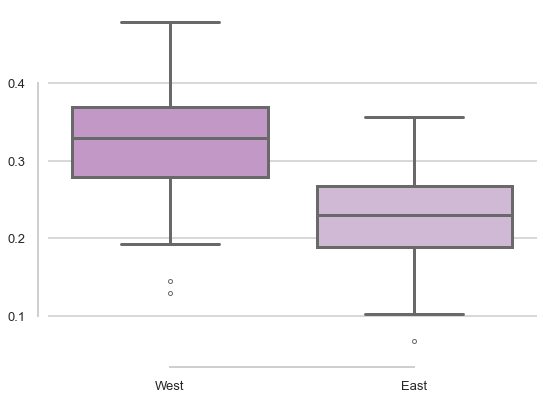

t-statistic: -10.840
p-value: 0.00000


In [45]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=sun_df,
    hue='region',
    legend=False,
    palette=[sun_west_median_color, sun_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = sun_df[sun_df['region'] == 'West']['darkness']
east_darkness = sun_df[sun_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## Shade individual boxplots

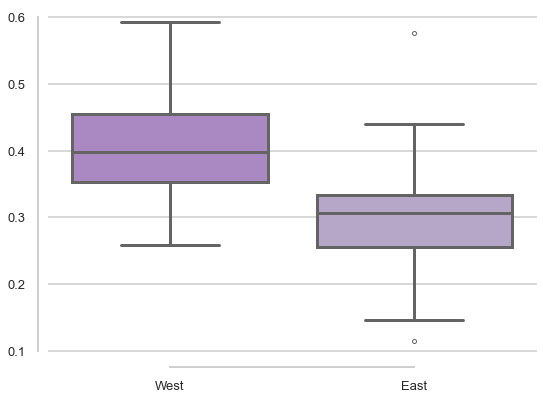

t-statistic: -8.563
p-value: 0.00000


In [46]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=shade_df,
    hue='region',
    legend=False,
    palette=[shade_west_median_color, shade_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = shade_df[shade_df['region'] == 'West']['darkness']
east_darkness = shade_df[shade_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## Partial individual boxplots

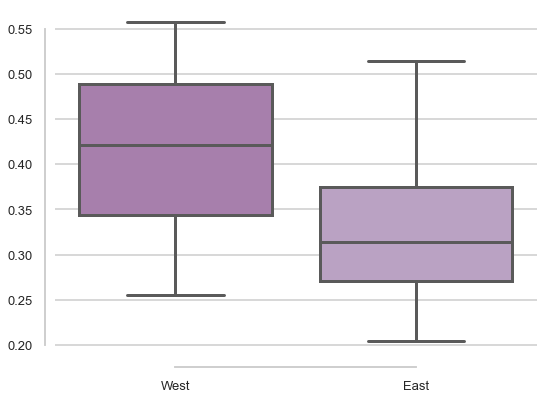

t-statistic: -3.399
p-value: 0.00142


In [47]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# set up plot
fig, ax = plt.subplots(figsize=(8, 6))

# specify boxplot params
sns.boxplot(
    x='region',
    y='darkness',
    data=partial_df,
    hue='region',
    legend=False,
    palette=[partial_west_median_color, partial_east_median_color],  # two shades of purple. could be the same, no preference here.
    linewidth=3,
    fliersize=4,
    order=['West', 'East'],
    hue_order=['West', 'East'],
    ax=ax
)

# no labels/titles
#ax.set_title('"Darkness" by Region (West vs. East)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(None)
ax.set_ylabel(None)

# tick parameters
ax.tick_params(axis='both', which='major', labelsize=13)

# this helps push the horiz bars away from the y
sns.despine(offset=10, trim=True)

# let's see it!
plt.tight_layout()
plt.show()

# t-test as well
west_darkness = partial_df[partial_df['region'] == 'West']['darkness']
east_darkness = partial_df[partial_df['region'] == 'East']['darkness']
t_stat, p_value = ttest_ind(east_darkness, west_darkness, equal_var=False)

# t-test results
print(f"t-statistic: {t_stat:.3f}")
print(f"p-value: {p_value:.5f}")

## All three together:

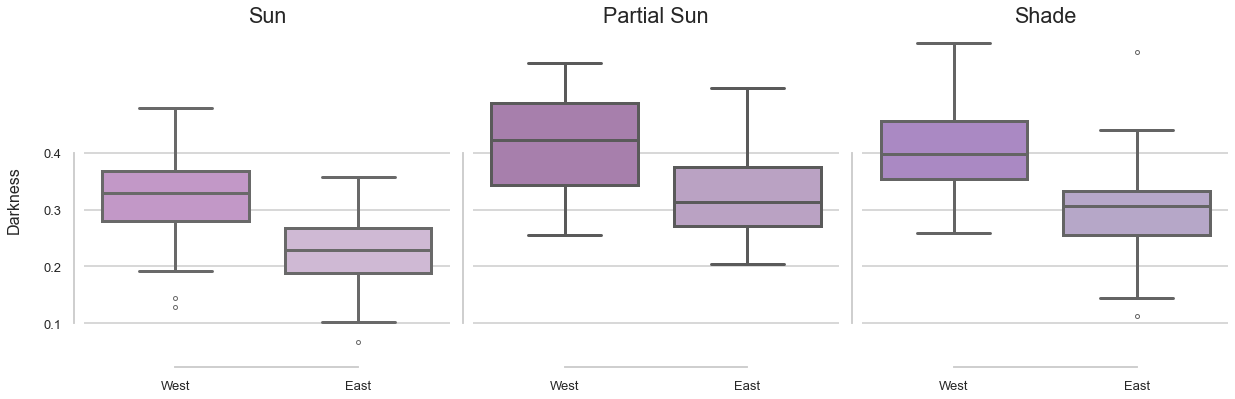

In [48]:
# make nice figure aesthetics
sns.set(style='whitegrid', context='talk', font_scale=1.2)

# 1 row, 3 columns, share y-axis
fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(18, 6))

# PLOT 1: sun_df
sns.boxplot(
    x='region', y='darkness', data=sun_df,
    hue='region', legend=False,
    palette=[sun_west_median_color, sun_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[0]
)
axes[0].set_title('Sun')
axes[0].set_xlabel(None)
axes[0].set_ylabel(None)
axes[0].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[0], offset=10, trim=True)

# PLOT 2: partial_df
sns.boxplot(
    x='region', y='darkness', data=partial_df,
    hue='region', legend=False,
    palette=[partial_west_median_color, partial_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[1]
)
axes[1].set_title('Partial Sun')
axes[1].set_xlabel(None)
axes[1].set_ylabel(None)
axes[1].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[1], offset=10, trim=True)

# PLOT 3: shade_df
sns.boxplot(
    x='region', y='darkness', data=shade_df,
    hue='region', legend=False,
    palette=[shade_west_median_color, shade_east_median_color],
    linewidth=3, fliersize=4,
    order=['West', 'East'], hue_order=['West', 'East'],
    ax=axes[2]
)
axes[2].set_title('Shade')
axes[2].set_xlabel(None)
axes[2].set_ylabel(None)
axes[2].tick_params(axis='both', which='major', labelsize=13)
sns.despine(ax=axes[2], offset=10, trim=True)

# y label
fig.text(0.04, 0.5, 'Darkness', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(rect=[0.05, 0, 1, 1])
plt.show()

# ANOVA

# first, with intersected data

In [49]:
# color ~ geo + light + geo*light

In [50]:
subdf_full = color_df[color_df.image_idx.isin(intersected_val.image_idx)]

# merge with the labels
subdf_full = subdf_full.merge(right=intersected_val,on="image_idx")

In [51]:
# clean up the df for readability
sub = subdf_full.copy()
sub["region"]   = sub["region"].astype("category")
sub["lighting"] = sub["lighting"].map({"s":"Sun", "h":"Shade", "p":"Partial"}).astype("category")

In [52]:
# fit ols model
# rresp ~ main effects + interaction
mod = smf.ols('darkness ~ C(region) * C(lighting)', data=sub).fit()

print(mod.summary())          # coefficient table

                            OLS Regression Results                            
Dep. Variable:               darkness   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     65.48
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.10e-48
Time:                        22:31:44   Log-Likelihood:                 469.87
No. Observations:                 371   AIC:                            -927.7
Df Residuals:                     365   BIC:                            -904.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [53]:
print(anova_lm(mod, typ=2))   # type-II ANOVA tablesub

                         sum_sq     df           F        PR(>F)
C(region)              0.896386    1.0  189.646608  4.861217e-35
C(lighting)            0.634677    2.0   67.138670  1.482720e-25
C(region):C(lighting)  0.003533    2.0    0.373776  6.883943e-01
Residual               1.725214  365.0         NaN           NaN


### Now remove the interaction term

In [54]:
mod_add = smf.ols('darkness ~ C(region) + C(lighting)', data=sub).fit()
print(mod_add.summary())          # coefficient table

                            OLS Regression Results                            
Dep. Variable:               darkness   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     109.3
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.45e-50
Time:                        22:31:44   Log-Likelihood:                 469.49
No. Observations:                 371   AIC:                            -931.0
Df Residuals:                     367   BIC:                            -915.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3213 

In [55]:
print(anova_lm(mod_add, typ=2))

               sum_sq     df           F        PR(>F)
C(region)    0.896386    1.0  190.296025  3.629527e-35
C(lighting)  0.634677    2.0   67.368576  1.199027e-25
Residual     1.728747  367.0         NaN           NaN


In [56]:
means = (sub
         .assign(pred = mod_add.fittedvalues)
         .groupby(['region','lighting'])
         .agg(mean_darkness = ('pred','mean'),
              n = ('darkness','size'))
         .reset_index())
print(means)

  region lighting  mean_darkness   n
0   East  Partial       0.321303  22
1   East    Shade       0.303772  73
2   East      Sun       0.226206  92
3   West  Partial       0.419682  26
4   West    Shade       0.402151  68
5   West      Sun       0.324585  90


/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_44925/3327148177.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['region','lighting'])


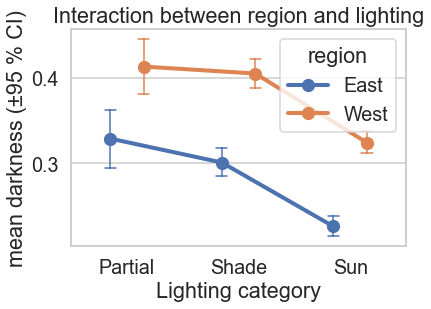

In [57]:
sns.pointplot(
    data=sub, x="lighting", y="darkness", hue="region",
    dodge=0.3, capsize=.1,
    err_kws={'linewidth': 1.5},
    errorbar=('ci', 95)
)
plt.ylabel("mean darkness (±95 % CI)")
plt.xlabel("Lighting category")
plt.title("Interaction between region and lighting")
plt.show()

# second, with Robin's data

In [58]:
# color ~ geo + light + geo*light

In [59]:
subdf_full = color_df[color_df.image_idx.isin(robin_val.image_idx)]

# merge with the labels
subdf_full = subdf_full.merge(right=robin_val,on="image_idx")

In [60]:
# clean up the df for readability
sub = subdf_full.copy()
sub["region"]   = sub["region"].astype("category")
sub["lighting"] = sub["lighting"].map({"s":"Sun", "h":"Shade", "p":"Partial"}).astype("category")

In [61]:
# fit ols model
# rresp ~ main effects + interaction
mod = smf.ols('darkness ~ C(region) * C(lighting)', data=sub).fit()

print(mod.summary())          # coefficient table

                            OLS Regression Results                            
Dep. Variable:               darkness   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     50.94
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.46e-42
Time:                        22:31:44   Log-Likelihood:                 575.50
No. Observations:                 500   AIC:                            -1139.
Df Residuals:                     494   BIC:                            -1114.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [62]:
print(anova_lm(mod, typ=2))   # type-II ANOVA tablesub

                         sum_sq     df           F        PR(>F)
C(region)              1.183436    1.0  199.584245  2.643940e-38
C(lighting)            0.368170    2.0   31.045562  1.992983e-13
C(region):C(lighting)  0.001487    2.0    0.125376  8.821929e-01
Residual               2.929176  494.0         NaN           NaN


### Now remove the interaction term

In [63]:
mod_add = smf.ols('darkness ~ C(region) + C(lighting)', data=sub).fit()
print(mod_add.summary())          # coefficient table

                            OLS Regression Results                            
Dep. Variable:               darkness   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     85.12
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.93e-44
Time:                        22:31:44   Log-Likelihood:                 575.38
No. Observations:                 500   AIC:                            -1143.
Df Residuals:                     496   BIC:                            -1126.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3003 

In [64]:
print(anova_lm(mod_add, typ=2))

               sum_sq     df           F        PR(>F)
C(region)    1.183436    1.0  200.290611  1.949009e-38
C(lighting)  0.368170    2.0   31.155438  1.795502e-13
Residual     2.930663  496.0         NaN           NaN


In [65]:
means = (sub
         .assign(pred = mod_add.fittedvalues)
         .groupby(['region','lighting'])
         .agg(mean_darkness = ('pred','mean'),
              n = ('darkness','size'))
         .reset_index())
print(means)

  region lighting  mean_darkness    n
0   East  Partial       0.300316   38
1   East    Shade       0.287543   98
2   East      Sun       0.237642  114
3   West  Partial       0.397739   40
4   West    Shade       0.384966   86
5   West      Sun       0.335065  124


/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_44925/3327148177.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['region','lighting'])


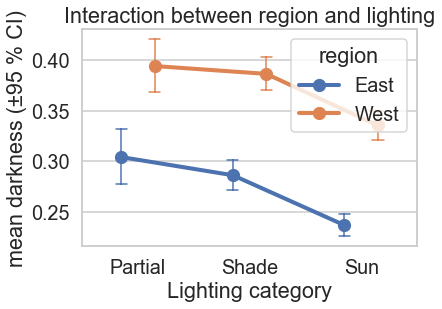

In [66]:
sns.pointplot(
    data=sub, x="lighting", y="darkness", hue="region",
    dodge=0.3, capsize=.1,
    err_kws={'linewidth': 1.5},
    errorbar=('ci', 95)
)
plt.ylabel("mean darkness (±95 % CI)")
plt.xlabel("Lighting category")
plt.title("Interaction between region and lighting")
plt.show()

# third, with Sam's data

In [67]:
# color ~ geo + light + geo*light

In [68]:
subdf_full = color_df[color_df.image_idx.isin(sam_val.image_idx)]

# merge with the labels
subdf_full = subdf_full.merge(right=sam_val,on="image_idx")

In [69]:
# clean up the df for readability
sub = subdf_full.copy()
sub["region"]   = sub["region"].astype("category")
sub["lighting"] = sub["lighting"].map({"s":"Sun", "h":"Shade", "p":"Partial"}).astype("category")

In [70]:
# fit ols model
# rresp ~ main effects + interaction
mod = smf.ols('darkness ~ C(region) * C(lighting)', data=sub).fit()

print(mod.summary())          # coefficient table

                            OLS Regression Results                            
Dep. Variable:               darkness   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     77.55
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           6.55e-60
Time:                        22:31:44   Log-Likelihood:                 618.36
No. Observations:                 499   AIC:                            -1225.
Df Residuals:                     493   BIC:                            -1199.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [71]:
print(anova_lm(mod, typ=2))   # type-II ANOVA tablesub

                         sum_sq     df           F        PR(>F)
C(region)              1.106004    1.0  222.502060  8.554479e-42
C(lighting)            0.750481    2.0   75.489589  2.511080e-29
C(region):C(lighting)  0.010041    2.0    1.010052  3.649525e-01
Residual               2.450584  493.0         NaN           NaN


### Now remove the interaction term

In [72]:
mod_add = smf.ols('darkness ~ C(region) + C(lighting)', data=sub).fit()
print(mod_add.summary())          # coefficient table

                            OLS Regression Results                            
Dep. Variable:               darkness   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     128.6
Date:                Mon, 28 Apr 2025   Prob (F-statistic):           1.38e-61
Time:                        22:31:44   Log-Likelihood:                 617.34
No. Observations:                 499   AIC:                            -1227.
Df Residuals:                     495   BIC:                            -1210.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3062 

In [73]:
print(anova_lm(mod_add, typ=2))

               sum_sq     df           F        PR(>F)
C(region)    1.106004    1.0  222.493024  8.065961e-42
C(lighting)  0.750481    2.0   75.486524  2.436258e-29
Residual     2.460626  495.0         NaN           NaN


In [74]:
means = (sub
         .assign(pred = mod_add.fittedvalues)
         .groupby(['region','lighting'])
         .agg(mean_darkness = ('pred','mean'),
              n = ('darkness','size'))
         .reset_index())
print(means)

  region lighting  mean_darkness    n
0   East  Partial       0.306190   44
1   East    Shade       0.303334   85
2   East      Sun       0.226666  121
3   West  Partial       0.400476   54
4   West    Shade       0.397620   82
5   West      Sun       0.320952  113


/var/folders/qh/c7rwx84921n2kznn09zb2pnh0000gn/T/ipykernel_44925/3327148177.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['region','lighting'])


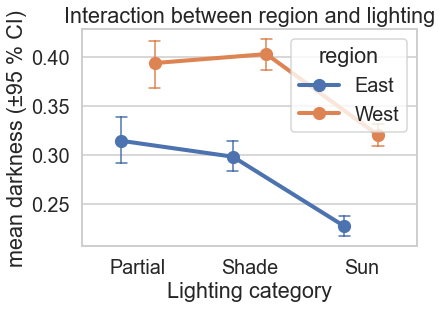

In [75]:
sns.pointplot(
    data=sub, x="lighting", y="darkness", hue="region",
    dodge=0.3, capsize=.1,
    err_kws={'linewidth': 1.5},
    errorbar=('ci', 95)
)
plt.ylabel("mean darkness (±95 % CI)")
plt.xlabel("Lighting category")
plt.title("Interaction between region and lighting")
plt.show()